# Implementing Logistic Classifier & Test the model on Amazon Product Review data set

In [136]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from math import sqrt
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
# pd.read_csv intelligently converts input to python datatypes.
products = pd.read_csv("amazon_baby_subset.csv")
products = products.astype(str)
print ('Shape : ', products.shape)

Shape :  (53072, 4)


In [138]:
# Change format of feature
products['rating'] = products['rating'].astype(int)
products['sentiment'] = products['sentiment'].astype(int)
# fill in N/A's in the review column
products = products.fillna({'reveiw':''}) 

In [139]:
# Write a function remove_punctuation that takes a line of text and removes all punctuation from that text
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried non-stop when I trie...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago. ...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"One of baby's first and favorite books, and it..."
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book! My son loves this ...


In [140]:
# read "important_words.json" file
with open('important_words.json') as data_file:
    important_words = json.load(data_file)

print('Number of importatnt words : ', len(important_words))

Number of importatnt words :  193


In [141]:
# now we proceed with the second item. For each word in important_words, 
# we compute a count for the number of times the word occurs in the review.
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

KeyboardInterrupt: 

In [ ]:
# Split train/valid data set
train_data = products.sample(frac=0.8)
validation_data = products.drop(train_data.index)

In [ ]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    features_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(features_matrix, label_array)

In [ ]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

print ('Input feature(X) : ', feature_matrix_train.shape, 'Output(y) : ', sentiment_train.shape)

## Building a logistic regression

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [221]:
class logistic_classifier():
    def __init__(self):
        self.coefficients = np.zeros(1)
        self.l2_penalty = 0;
        self.iteration = 501
        self.learning_rate = 0
    
    def predict_probability(self, feature_matrix):
        #Take dot product of feature_matrix and coefficients
        score = np.dot(feature_matrix, self.coefficients)
        #Compute P(y_i = +1|x_i, w) using the link function
        predictions = 1.0/(1 + np.exp(-score))
        return predictions
    
    #Compute derivative of log likelihood with respect to a single coefficient
    def feature_derivative_with_L2(self, errors, feature, coefficient, feature_is_constant):
        #Compute the dot product of errors and feature(without L2 penalty)
        derivative = np.dot(errors, feature)
        
        #add L2 penalty term for any feature that isn't the intercept
        if not feature_is_constant:
            derivative -= 2 * self.l2_penalty * coefficient
        return derivative
    
    def compute_log_likelihood_with_L2(self, feature_matrix, sentiment):
        indicator = (sentiment == +1)
        scores = np.dot(feature_matrix, self.coefficients)
        lp = np.sum((indicator-1) * scores - np.log(1. + np.exp(-scores))) - self.l2_penalty*np.sum(self.coefficients[1:]**2)
        return lp
    
    def fit(self, feature_matrix, sentiment, learning_rate, l2_penalty, iteration):
        self.learning_rate = learning_rate
        self.l2_penalty = l2_penalty
        self.iteration = iteration
        self.coefficients = np.zeros(feature_matrix.shape[1])
        print (self.l2_penalty, self.iteration, self.learning_rate)
        for itr in range(iteration):
            #Predict P(y_i = +1|x_1,w) using your predict_probability() function
            predictions = self.predict_probability(feature_matrix)

            #compute indicator value for (y_i = +1)
            indicator = (sentiment==+1)

            #Compute the errors as indicator - predictions
            errors = indicator - predictions
        
            for j in range(len(self.coefficients)): #loop over each coefficient
                is_intercept = (j==0)
                #Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
                #compute the derivative for coefficients[j]. Save it in a variable called derivative
                derivative = self.feature_derivative_with_L2(errors, feature_matrix[:,j], self.coefficients[j], is_intercept)
                #add step size times the derivative to the current coefficient(l2_penalty is already added)
                self.coefficients[j] += learning_rate * derivative

            #Checking whether log likelihood is increasing
            if (itr <= 100 and itr %10 ==0) or \
                (itr <= 1000 and itr %100 ==0) or (itr <= 10000 and itr %1000 ==0) or itr % 10000 ==0:
                    lp = self.compute_log_likelihood_with_L2(feature_matrix, sentiment)
                    print ('iteration %*d : log likelihood of observed labels = %.8f' % \
                    (int(np.ceil(np.log10(iteration ))), itr, lp))
       
    def get_accuracy(self, feature_matrix, sentiment):
        #compute scores using feature_matrix, coefficients
        scores = np.dot(feature_matrix, self.coefficients)
        #threshold scores by 0
        positive = scores > 0
        negative = scores <= 0
        scores[positive] = 1
        scores[negative] = -1

        correct = float((scores == sentiment).sum())
        total = float(len(sentiment))
        accuracy = float(correct / total)
        return accuracy

In [190]:
learning_rate = 5e-6
iteration = 501

In [191]:
l2_penalty = 0
model_0_penalty = logistic_classifier()
model_0_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

0 501 5e-06
iteration   0 : log likelihood of observed labels = -29287.06390223
iteration  10 : log likelihood of observed labels = -28088.62554003
iteration  20 : log likelihood of observed labels = -27175.78290343
iteration  30 : log likelihood of observed labels = -26455.27140737
iteration  40 : log likelihood of observed labels = -25871.23452654
iteration  50 : log likelihood of observed labels = -25387.20269141
iteration  60 : log likelihood of observed labels = -24978.60537531
iteration  70 : log likelihood of observed labels = -24628.36640453
iteration  80 : log likelihood of observed labels = -24324.27001726
iteration  90 : log likelihood of observed labels = -24057.34770536
iteration 100 : log likelihood of observed labels = -23820.86191965
iteration 200 : log likelihood of observed labels = -22382.35498633
iteration 300 : log likelihood of observed labels = -21682.05668708
iteration 400 : log likelihood of observed labels = -21260.57132828
iteration 500 : log likelihood of ob

In [192]:
l2_penalty = 5
model_5_penalty = logistic_classifier()
model_5_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

5 501 5e-06
iteration   0 : log likelihood of observed labels = -29287.06750120
iteration  10 : log likelihood of observed labels = -28089.29823451
iteration  20 : log likelihood of observed labels = -27177.89617647
iteration  30 : log likelihood of observed labels = -26459.26322164
iteration  40 : log likelihood of observed labels = -25877.35871857
iteration  50 : log likelihood of observed labels = -25395.60689297
iteration  60 : log likelihood of observed labels = -24989.37313102
iteration  70 : log likelihood of observed labels = -24641.54106185
iteration  80 : log likelihood of observed labels = -24339.86891477
iteration  90 : log likelihood of observed labels = -24075.37094973
iteration 100 : log likelihood of observed labels = -23841.29801028
iteration 200 : log likelihood of observed labels = -22425.36293482
iteration 300 : log likelihood of observed labels = -21744.45142306
iteration 400 : log likelihood of observed labels = -21339.69862901
iteration 500 : log likelihood of ob

In [193]:
l2_penalty = 10
model_10_penalty = logistic_classifier()
model_10_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

10 501 5e-06
iteration   0 : log likelihood of observed labels = -29287.07110017
iteration  10 : log likelihood of observed labels = -28089.97048689
iteration  20 : log likelihood of observed labels = -27180.00672470
iteration  30 : log likelihood of observed labels = -26463.24743113
iteration  40 : log likelihood of observed labels = -25883.46754228
iteration  50 : log likelihood of observed labels = -25403.98499487
iteration  60 : log likelihood of observed labels = -25000.10109681
iteration  70 : log likelihood of observed labels = -24654.65933405
iteration  80 : log likelihood of observed labels = -24355.39200347
iteration  90 : log likelihood of observed labels = -24093.29622028
iteration 100 : log likelihood of observed labels = -23861.61131254
iteration 200 : log likelihood of observed labels = -22467.87354180
iteration 300 : log likelihood of observed labels = -21805.79445236
iteration 400 : log likelihood of observed labels = -21417.09158280
iteration 500 : log likelihood of o

In [194]:
l2_penalty = 1e2
model_1e2_penalty = logistic_classifier()
model_1e2_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

100.0 501 5e-06
iteration   0 : log likelihood of observed labels = -29287.13588163
iteration  10 : log likelihood of observed labels = -28101.99578803
iteration  20 : log likelihood of observed labels = -27217.53511752
iteration  30 : log likelihood of observed labels = -26533.68150895
iteration  40 : log likelihood of observed labels = -25990.84878768
iteration  50 : log likelihood of observed labels = -25550.43466554
iteration  60 : log likelihood of observed labels = -25186.59572719
iteration  70 : log likelihood of observed labels = -24881.46896198
iteration  80 : log likelihood of observed labels = -24622.33941284
iteration  90 : log likelihood of observed labels = -24399.91656670
iteration 100 : log likelihood of observed labels = -24207.25382419
iteration 200 : log likelihood of observed labels = -23155.94945284
iteration 300 : log likelihood of observed labels = -22754.52380386
iteration 400 : log likelihood of observed labels = -22565.38937010
iteration 500 : log likelihood o

In [195]:
l2_penalty = 1e3
model_1e3_penalty = logistic_classifier()
model_1e3_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

1000.0 501 5e-06
iteration   0 : log likelihood of observed labels = -29287.78369630
iteration  10 : log likelihood of observed labels = -28214.76539715
iteration  20 : log likelihood of observed labels = -27549.02849720
iteration  30 : log likelihood of observed labels = -27121.79958803
iteration  40 : log likelihood of observed labels = -26841.01785063
iteration  50 : log likelihood of observed labels = -26652.85945965
iteration  60 : log likelihood of observed labels = -26524.74054687
iteration  70 : log likelihood of observed labels = -26436.33838450
iteration  80 : log likelihood of observed labels = -26374.65551489
iteration  90 : log likelihood of observed labels = -26331.20326486
iteration 100 : log likelihood of observed labels = -26300.33933756
iteration 200 : log likelihood of observed labels = -26222.84056862
iteration 300 : log likelihood of observed labels = -26218.95373328
iteration 400 : log likelihood of observed labels = -26218.70054593
iteration 500 : log likelihood 

In [222]:
l2_penalty = 1e5
model_1e5_penalty = logistic_classifier()
model_1e5_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

100000.0 501 5e-06
iteration   0 : log likelihood of observed labels = -29359.04330973
iteration  10 : log likelihood of observed labels = -29358.94869675
iteration  20 : log likelihood of observed labels = -29358.93904964
iteration  30 : log likelihood of observed labels = -29358.93555134
iteration  40 : log likelihood of observed labels = -29358.93428275
iteration  50 : log likelihood of observed labels = -29358.93382273
iteration  60 : log likelihood of observed labels = -29358.93365591
iteration  70 : log likelihood of observed labels = -29358.93359542
iteration  80 : log likelihood of observed labels = -29358.93357348
iteration  90 : log likelihood of observed labels = -29358.93356553
iteration 100 : log likelihood of observed labels = -29358.93356264
iteration 200 : log likelihood of observed labels = -29358.93356100
iteration 300 : log likelihood of observed labels = -29358.93356100
iteration 400 : log likelihood of observed labels = -29358.93356100
iteration 500 : log likelihoo

# Visualize the result

In [224]:
#but we gonna use this DataFrame
table = pd.DataFrame({'word': important_words, 
                      'l2_penalty_0': model_0_penalty.coefficients[1:],
                      'l2_penalty_5': model_5_penalty.coefficients[1:],
                      'l2_penalty_10': model_10_penalty.coefficients[1:],
                      'l2_penalty_1e2': model_1e2_penalty.coefficients[1:],
                      'l2_penalty_1e3': model_1e3_penalty.coefficients[1:],
                      'l2_penalty_1e5': model_1e5_penalty.coefficients[1:]})

In [228]:
table = table.sort_values(['l2_penalty_0'], ascending=[0])
table = table[['word', 'l2_penalty_0', 'l2_penalty_5', 'l2_penalty_10', 'l2_penalty_1e2', 'l2_penalty_1e3', 'l2_penalty_1e5']]
positive_words = table[1:6]['word']
negative_words = table[-6:-1]['word']
print ('Positive words : \n', positive_words)
print ('Negative words : \n', negative_words)

Positive words : 
 3        love
7        easy
2       great
33    perfect
82      happy
Name: word, dtype: object
Negative words : 
 99          thought
96            money
168        returned
105    disappointed
113          return
Name: word, dtype: object


In [229]:
table.head()

,word,l2_penalty_0,l2_penalty_5,l2_penalty_10,l2_penalty_1e2,l2_penalty_1e3,l2_penalty_1e5
22,loves,1.079773,1.068865,1.058152,0.894294,0.006031,0.006031
3,love,1.073764,1.064262,1.054938,0.913068,0.008937,0.008937
7,easy,1.032797,1.023669,1.014713,0.878385,0.008436,0.008436
2,great,0.765449,0.759323,0.753307,0.661158,0.006930,0.006930
33,perfect,0.714365,0.706664,0.699097,0.582801,0.003026,0.003026


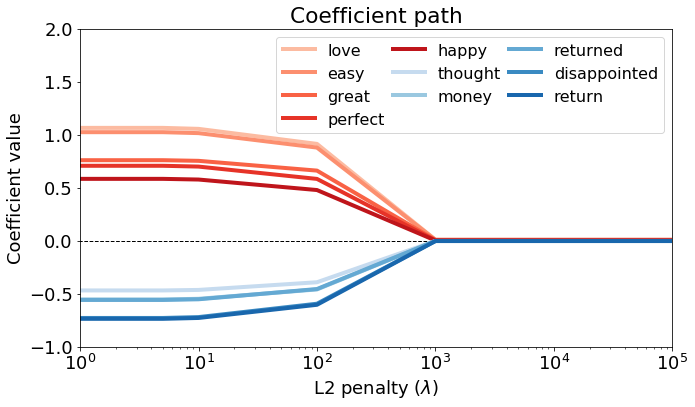

In [230]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 5, 10, 1e2, 1e3, 1e5])

In [236]:
def get_accuracy(feature_matrix, coefficients, sentiment):
    #compute scores using feature_matrix, coefficients
    scores = np.dot(feature_matrix, coefficients)
    #threshold scores by 0
    positive = scores > 0
    negative = scores <= 0
    scores[positive] = 1
    scores[negative] = -1

    correct = float((scores == sentiment).sum())
    total = float(len(sentiment))
    accuracy = float(correct / total)
    return accuracy

In [240]:
train_accuracy = {}
train_accuracy[0] = model_0_penalty.get_accuracy(feature_matrix_train, sentiment_train)
train_accuracy[5] = model_5_penalty.get_accuracy(feature_matrix_train, sentiment_train)
train_accuracy[10] = model_10_penalty.get_accuracy(feature_matrix_train, sentiment_train)
train_accuracy[1e2] = model_1e2_penalty.get_accuracy(feature_matrix_train, sentiment_train)
train_accuracy[1e3] = model_1e3_penalty.get_accuracy(feature_matrix_train, sentiment_train)
train_accuracy[1e5] = model_1e5_penalty.get_accuracy(feature_matrix_train, sentiment_train)
print (train_accuracy)

{0: 0.7699844552263413, 5: 0.7699844552263413, 10: 0.7699137971642565, 100.0: 0.7690894531065995, 1000.0: 0.7244571105563145, 100000.0: 0.7244571105563145}


In [241]:
validation_accuracy = {}
validation_accuracy[0] = model_0_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
validation_accuracy[5] = model_5_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
validation_accuracy[10] = model_10_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
validation_accuracy[1e2] = model_1e2_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
validation_accuracy[1e3] = model_1e3_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
validation_accuracy[1e5] = model_1e5_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
print (validation_accuracy)

{0: 0.7658752590917656, 5: 0.7654983983418127, 10: 0.7654041831543245, 100.0: 0.7634256642170718, 1000.0: 0.7218767665347654, 100000.0: 0.7218767665347654}


<function matplotlib.pyplot.tight_layout>

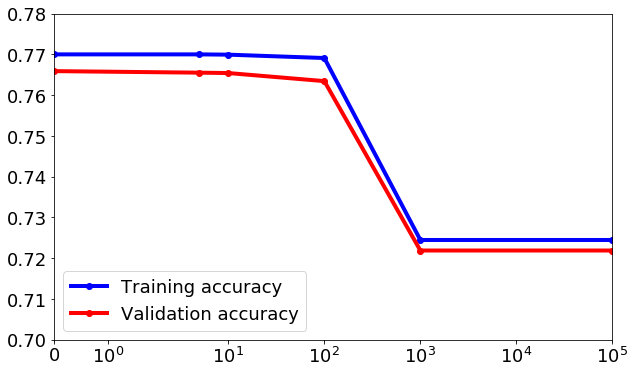

In [243]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e5, 0.70, 0.78])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout